## Facial Emotion Recognition

Download data from Kaggle : https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

I used Google colab platform to run my Jupyter notebook. So mounting your google drive is necessary to run the code. 

####Data Preparation:
- Download 'archive.zip' from Kaggle website
- Upload to your google drive

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

# Unzip the dataset
!unzip -q '/content/drive/MyDrive/archive.zip' -d '/content/data/'

Mounted at /content/drive/


In [2]:
# Package setup
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils

from keras import regularizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

%matplotlib inline

In [3]:
# Initialization
train_data_dir = '/content/data/train'
test_data_dir = '/content/data/test'

# Random Seed
tf.random.set_seed(3)
np.random.seed(3)

# Parameters
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.01
NUM_CLASSES = 7
CLASS_LABELS  = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', "Surprised"]

Shape of an image = (48, 48)


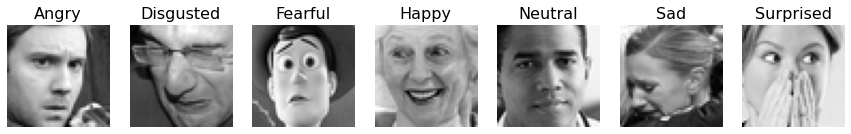

In [4]:
# Sample images from dataset
def show_image(path_image, title_card):
  im = plt.imread(path_image)
  plt.axis('off')
  plt.imshow(im, cmap='gray')
  plt.title(title_card, fontsize=16)

plt.figure(figsize=(15,15))
plt.subplot(1, 7, 1)
show_image('/content/data/train/angry/im0.png', 'Angry')
plt.subplot(1, 7, 2)
show_image('/content/data/train/disgusted/im3.png', 'Disgusted')
plt.subplot(1, 7, 3)
show_image('/content/data/train/fearful/im100.png', 'Fearful')
plt.subplot(1, 7, 4)
show_image('/content/data/train/happy/im5.png', 'Happy')
plt.subplot(1, 7, 5)
show_image('/content/data/train/neutral/im46.png', 'Neutral')
plt.subplot(1, 7, 6)
show_image('/content/data/train/sad/im78.png', 'Sad')
plt.subplot(1, 7, 7)
show_image('/content/data/train/surprised/im99.png', 'Surprised')

# Shape of an image
im = plt.imread('/content/data/train/angry/im0.png')
print(f'Shape of an image = {im.shape}')

In [10]:
# Data generator for training and testing
# Setup data generators
# Splitting train data to 80% for train and 20%  for validation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator(rescale = 1./255.)

# Train data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle  = True,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training') # set as training data

# Validation data
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle  = True,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation') # set as validation data

# Test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle  = False,
    color_mode='grayscale',
    class_mode='categorical')

# Class weight
# Due to imbalanced train data, applying weights per class to balance dataset
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_generator.classes),
                                     y = train_generator.classes)
class_weights = class_weights / min(class_weights)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
print('-------\nClass Weights:')
class_weights

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
-------
Class Weights:


{0: 1.8060075093867334,
 1: 16.53868194842407,
 2: 1.7608297742525931,
 3: 1.0,
 4: 1.4531722054380665,
 5: 1.4937888198757763,
 6: 2.275128104059913}

Total number of samples:
Train=22968
Validation=5741
Test=7178


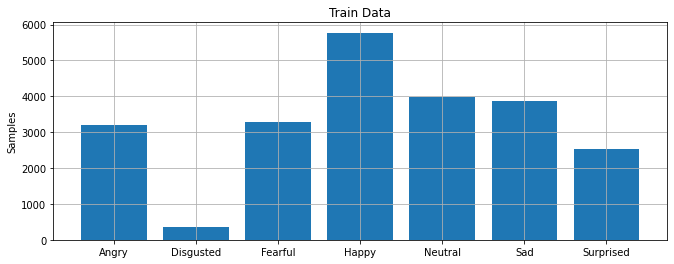

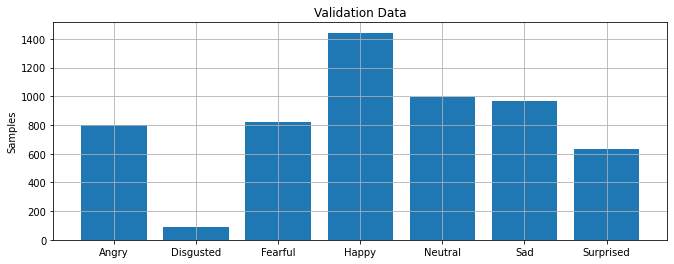

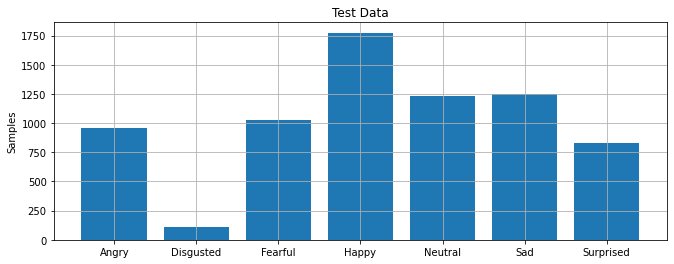

In [7]:
# Bar plot - Samples across classes

# Count of images per class
def count_images_per_class(generator_t):
  return [list(generator_t.classes).count(i) for i in np.unique(generator_t.classes)]

count_train = count_images_per_class(train_generator)
count_validation = count_images_per_class(validation_generator)
count_test = count_images_per_class(test_generator)

print(f'Total number of samples:\nTrain={len(train_generator.classes)}\nValidation={len(validation_generator.classes)}\nTest={len(test_generator.classes)}')

# Train
plt.figure(figsize=(11,4))
plt.bar(CLASS_LABELS, count_train)
plt.title('Train Data')
plt.ylabel('Samples')
plt.grid()

# Validation
plt.figure(figsize=(11,4))
plt.bar(CLASS_LABELS, count_validation)
plt.title('Validation Data')
plt.ylabel('Samples')
plt.grid()

# Test
plt.figure(figsize=(11,4))
plt.bar(CLASS_LABELS, count_test)
plt.title('Test Data')
plt.ylabel('Samples')
plt.grid()

In [8]:
# Misc functions

def plot_model_performance(history_t):
  # Plot Loss, Accuracy for epochs
  train_loss = history_t.history['loss']
  val_loss = history_t.history['val_loss']
  train_acc = history_t.history['accuracy']
  val_acc = history_t.history['val_accuracy']

  epochs = range(1,len(train_loss)+1)

  plt.figure(figsize=(11,8))
  plt.subplot(2,1,1)
  plt.plot(epochs, train_loss, '-o', label='Train Loss')
  plt.plot(epochs, val_loss, '-o', label='Validation Loss')
  plt.title('Loss')
  plt.grid()
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(epochs, train_acc, '-o', label='Train Accuracy')
  plt.plot(epochs, val_acc, '-o', label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.title('Accuracy')
  plt.ylim((0,1))
  plt.grid()
  plt.legend()
  plt.show()

def generate_confusion_matrix(y_label, y_pred):
  # Confusion matrix given label and prediction
  cm_data = confusion_matrix(y_label , y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  cmn = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  ax = sns.heatmap(cmn, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.0%')
  plt.show()

  plt.figure(figsize = (11,8))
  plt.title('Accuracy per Class', fontsize = 20)
  plt.bar(CLASS_LABELS, 100*np.diag(cmn), color ='maroon',width = 0.4)
  plt.ylim((0,100))
  plt.grid()
  plt.show()

def performance_by_class(model_t, data_gen):
  # Confusion matrix for class given model and data generator
  preds = model_t.predict(data_gen)
  y_preds = np.argmax(preds , axis = 1 )
  y_test = np.array(data_gen.labels)
  generate_confusion_matrix(y_test, y_preds)

## Model Callbacks
# Early stopping
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=10,
                                                         verbose= 1 ,
                                                         mode='min',
                                                         restore_best_weights=True)
# Reduce LR on Plateau
rlrop = ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001)

In [9]:
## Model Architecture

def build_ferm():
  # 5 conv layer with 4,496,902 trainables
  model= models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), padding='same'))
  model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same' ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128,(5,5), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))
      
  model.add(layers.Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01), ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten()) 
  model.add(layers.Dense(256,activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))
      
  model.add(layers.Dense(512,activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
  return model

In [11]:
# # Model Ferm
# Class weights

mdl = build_ferm()
mdl.summary()
mdl.compile(
    optimizer = SGD(learning_rate=0.01, nesterov=True, momentum=0.9, decay=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )
filepath_mdl = '/content/drive/MyDrive/mdl_best.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath_mdl, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
history_mdl = mdl.fit(train_generator, epochs=100, batch_size=64, validation_data=validation_generator,
                         class_weight=class_weights,
                         callbacks=[rlrop, checkpoint]) # checkpoint, earlyStoppingCallback

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)      

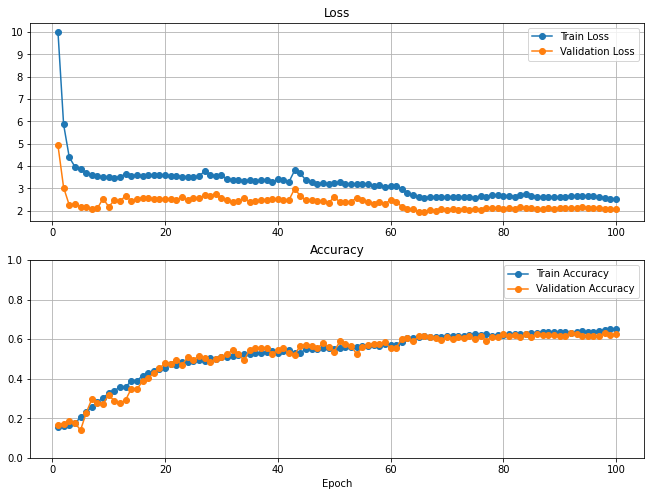

113/113 [==============================] - 2s 19ms/step


<ipython-input-8-321a04c8e34e>:36: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cmn = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


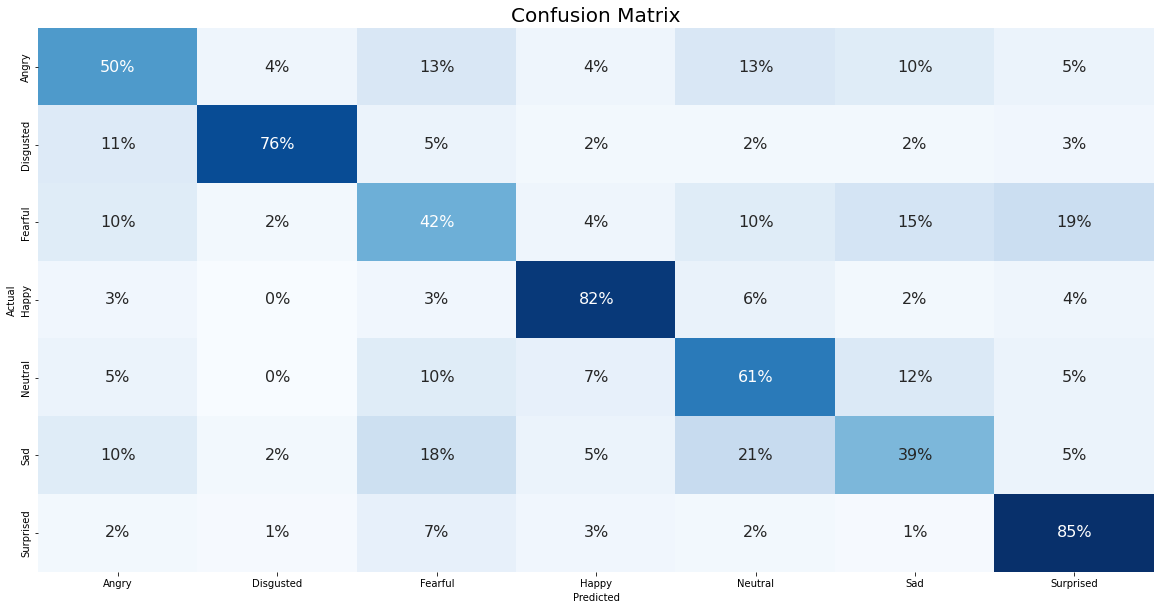

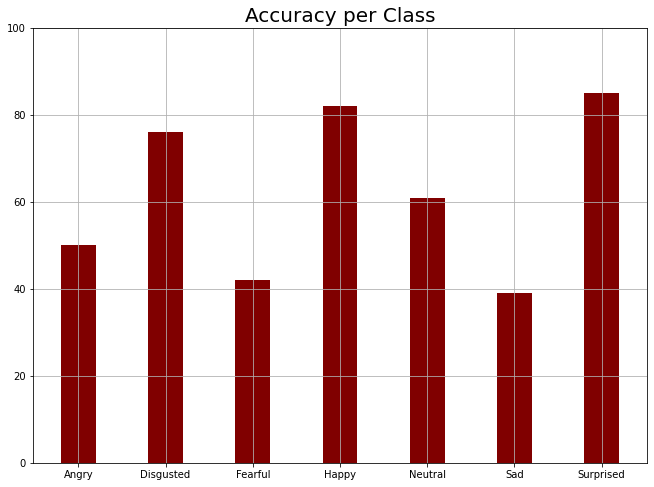

In [12]:
## Model Performance
# Performance
plot_model_performance(history_mdl)

# Confusion Matrix
mdloi = load_model(filepath_mdl)
mdloi.evaluate(test_generator)
performance_by_class(mdloi, test_generator)

In [13]:
# Read image from path and convert to array
def get_img_array(img_path, size):
  # Load and normalize image
  img = utils.load_img(img_path, target_size=size,  color_mode="grayscale")
  array = utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array /= 255.
  return array

def plot_activations(img_path):
  # Convert to 4D tensor
  img_tensor = get_img_array(img_path, (48, 48))

  # Extracts the outputs of the top 5 layers:
  layer_outputs = [layer.output for layer in mdloi.layers[:5]]
  activation_model = models.Model(inputs=mdloi.input, outputs=layer_outputs)
  activations = activation_model.predict(img_tensor)

  # These are the names of the layers, so can have them as part of our plot
  layer_names = []
  for layer in mdloi.layers[:5]:
      layer_names.append(layer.name)

  images_per_row = 16

  # 1 - Max Pooling Layer
  # 2, 4 - Convolutional Layers
  select_layers = [0, 1, 3] 
  select_activations = [activations[i] for i in select_layers]
  select_layer_names = [layer_names[i] for i in select_layers]

  # Now let's display our feature maps
  for layer_name, layer_activation in zip(select_layer_names, select_activations):
      # This is the number of features in the feature map
      n_features = layer_activation.shape[-1]

      # The feature map has shape (1, size, size, n_features)
      size = layer_activation.shape[1]

      # We will tile the activation channels in this matrix
      n_cols = n_features // images_per_row
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      # We'll tile each filter into this big horizontal grid
      for col in range(n_cols):
          for row in range(images_per_row):
              channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
              # Post-process the feature to make it visually palatable
              channel_image -= channel_image.mean()
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size,
                          row * size : (row + 1) * size] = channel_image

      # Display the grid
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')
      
  plt.show()


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Class weightage 
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

### Visualization of Filters

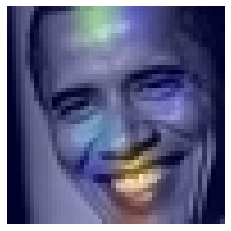

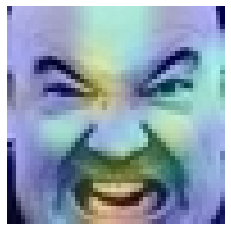

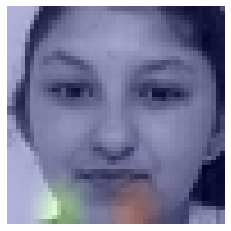

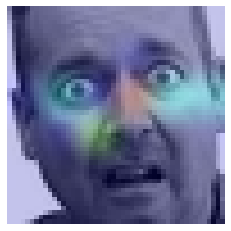

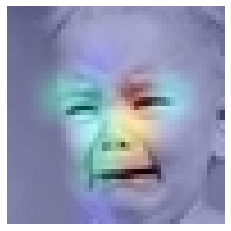

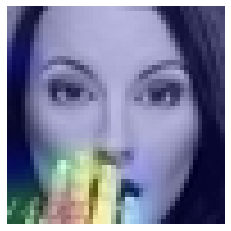

In [15]:
list_img_path = ['/content/data/test/happy/im217.png',
                 '/content/data/test/angry/im164.png',
                 '/content/data/test/neutral/im378.png',
                 '/content/data/test/fearful/im107.png',
                 '/content/data/test/sad/im22.png',
                 '/content/data/test/surprised/im500.png']

for img_path in list_img_path:
  # Prepare image
  img_array = get_img_array(img_path, size=(IMG_HEIGHT, IMG_WIDTH))

  # Remove last layer's softmax
  mdloi.layers[-1].activation = None

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, mdloi, 'conv2d_9')

  # Superimposed image
  display_gradcam(img_path, heatmap)